# 利用tensorflow2.0卷积神经网络进行卫星图片分类实例操作详解
来源：https://blog.csdn.net/lys_828/article/details/101322246

In [1]:
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version: {}, GPU is {}'.format(tf.__version__, tf.test.is_gpu_available()))
if tf.test.is_gpu_available():
    gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
    #下面的方式是设置Tensorflow固定消耗GPU:0的2GB显存（该设置对代码缺陷（GPU需求内存超物理GPU内存时异常退出）不起作用）。
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
    )

Tensorflow version: 2.0.0, GPU is True


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib
import random
import IPython.display as display

In [3]:
#根据标签值获取标签对应的名称
def caption_image(label):
    return {0: 'airplane', 1: 'lake'}.get(label)

In [4]:
data_dir = './2_class'

In [5]:
#根据相对目录路径，读取文件清单，标签清单，文件数（文件被random打乱）
#一级目录为airplan、lake，分别表示机场、湖泊，二级目录为对应的图片文件
def loadfiles(data_dir , randomflag = True):
    data_root = pathlib.Path(data_dir)
    
    #print(data_root)
    #for item in data_root.iterdir():
    #    print(item)
    
    all_image_paths = list(data_root.glob('*/*'))
    image_count = len(all_image_paths)
    
    #print(all_image_paths[:3],all_image_paths[-3:])
    
    #打乱顺序
    all_image_paths = [str(path) for path in all_image_paths]
    if randomflag:
        random.shuffle(all_image_paths)
        #print(all_image_paths[:5])
    
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    #print(label_names)
    #对排序后的label按目录名进行排序
    label_to_index = dict((name, index) for index,name in enumerate(label_names))
    #print(label_to_index)
    
    #根据文件的目录名生成label结果集
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
    #print(all_image_labels[:5])
    
    return all_image_paths, all_image_labels, image_count, label_names

In [6]:
def loadcheckfiles(data_dir):
    data_root = pathlib.Path(data_dir)
    
    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]
    return all_image_paths

In [7]:
all_image_paths, all_image_labels, image_count, label_names = loadfiles(data_dir)

#随机抽查几张图片及其标签值
for n in range(3):
    image_index = random.choice(range(len(all_image_paths)))
    display.display(display.Image(all_image_paths[image_index]))
    print(image_index, caption_image(all_image_labels[image_index]))
    #print()
#加载和格式化图像

img_path = all_image_paths[0]
print(img_path)

img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

img_tensor = tf.cast(img_tensor, tf.float32)
img_final = img_tensor/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

In [20]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

In [21]:
#加载并预处理图像，使之值介于[0,1]范围内
def load_and_preprocess_image(path , size=[IMAGE_WIDTH , IMAGE_HEIGHT]):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    return image

In [22]:
#按文件索引进行显示图片
def imageshow(imageindex):
    image_path = all_image_paths[imageindex]
    label = all_image_labels[imageindex]

    plt.imshow(load_and_preprocess_image(image_path))
    plt.grid(False)
    plt.xlabel(caption_image(label))
    print()

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

In [24]:
def datasplit(data , batch_size = BATCH_SIZE, test_rate = 0.2):
    path_ds = tf.data.Dataset.from_tensor_slices(data)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
    image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
    #for label in label_ds.take(10):
    #    print(label_names[label.numpy()])
    #print(image_label_ds)
    image_count = len(all_image_paths)
    test_count = int(image_count*0.2)
    train_count = image_count - test_count
    train_data = image_label_ds.skip(test_count)
    test_data = image_label_ds.take(test_count)

    train_data = train_data.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_count))
    train_data = train_data.batch(BATCH_SIZE)
    train_data = train_data.prefetch(buffer_size=AUTOTUNE)
    #print(train_data)

    test_data = test_data.batch(BATCH_SIZE)
    
    return train_data , train_count , test_data , test_count

In [25]:
train_data , train_count , test_data , test_count = datasplit(all_image_paths)

建立模型

In [14]:
model = tf.keras.Sequential()   #顺序模型
if IMAGE_WIDTH == 256 and IMAGE_HEIGHT == 256:
    #正常模式（有充足的GPU内存或CPU模式）
    model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
else:
    #适应小内存，input_shape=(128,128,3)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), activation='relu'))
    #model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    #model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    #model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())
    #model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
    #model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 256)       295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 512)      

In [28]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc']
)

In [29]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = test_count//BATCH_SIZE

In [30]:
SAVE_PATH = './airplan-lake.model/'

#模型的加载
model = tf.keras.models.load_model(SAVE_PATH + 'model')

In [31]:
import datetime
time_start = datetime.datetime.now()
time_keep = 0
history = model.fit(train_data, epochs=20, steps_per_epoch=steps_per_epoch, validation_data=test_data, validation_steps=validation_steps)
time_stop = datetime.datetime.now()
time_keep = time_stop - time_start
print('model fit in ' , time_keep)

Train for 35 steps, validate for 8 steps
Epoch 1/20
35/35 [==============================] - 14s 387ms/step - loss: 0.9422 - acc: 0.4768 - val_loss: 0.6708 - val_acc: 0.5039
Epoch 2/20
35/35 [==============================] - 10s 295ms/step - loss: 0.6238 - acc: 0.6402 - val_loss: 0.1887 - val_acc: 0.9258
Epoch 3/20
35/35 [==============================] - 10s 295ms/step - loss: 0.2326 - acc: 0.9330 - val_loss: 0.0914 - val_acc: 0.9766
Epoch 4/20
35/35 [==============================] - 10s 295ms/step - loss: 0.1297 - acc: 0.9598 - val_loss: 0.0696 - val_acc: 0.9766
Epoch 5/20
35/35 [==============================] - 10s 296ms/step - loss: 0.1402 - acc: 0.9625 - val_loss: 0.1662 - val_acc: 0.9727
Epoch 6/20
35/35 [==============================] - 10s 296ms/step - loss: 0.1704 - acc: 0.9607 - val_loss: 0.0809 - val_acc: 0.9766
Epoch 7/20
35/35 [==============================] - 10s 295ms/step - loss: 0.1395 - acc: 0.9661 - val_loss: 0.0705 - val_acc: 0.9766
Epoch 8/20
35/35 [==========

In [32]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

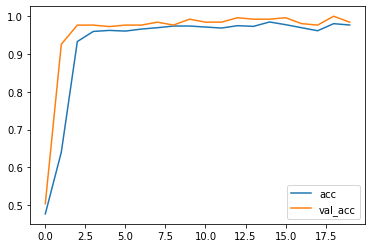

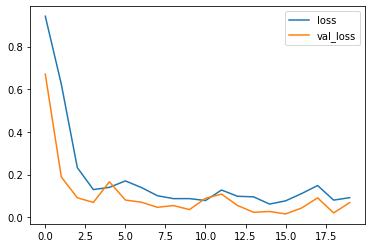

In [33]:
#显示正确率
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()
plt.show()

#显示错误率
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()
plt.show()

In [34]:
#模型评估（直接采用验证集来评估，结果应该跟val_acc一致）
steps = validation_steps
model.evaluate(test_data, steps= steps) 

8/8 [==============================] - 1s 118ms/step - loss: 0.0687 - acc: 0.9844


[0.06874996516853571, 0.984375]

In [35]:
def imagepred(image_path , label , withshow = True):
    #模型预测
    image = load_and_preprocess_image(image_path)
    if withshow:
        plt.imshow(image)
        plt.grid(False)
        plt.xlabel(caption_image(label))
        plt.show()
    
    image1 = tf.io.read_file(image_path)
    image1 = tf.image.decode_jpeg(image1, channels=3)
    image1 = tf.image.resize(image1, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image1 = tf.cast(image1, tf.float32)
    image1 = image1/255.0  # normalize to [0,1] range

    image2 = np.array([image1.numpy()])
    
    result = model.predict(image2)

    result_value = tf.argmax(result,1).numpy()
    if label == -1:
        print('pred label={},{}({})'.format(result_value[0] , caption_image(result_value[0]) , image_path))
    elif result_value != label:
        print('(error)pred label=' , result_value[0] , caption_image(result_value[0])) 
    else:
        print('(right)pred label=' , result_value[0] , caption_image(result_value[0])) 

In [36]:
def imagepredi(index, withshow = True):
    #获取要预测的图片路径及标签，并调用imagepred进行预测校验
    image_path = all_image_paths[index]
    label = all_image_labels[index]
    return imagepred(image_path , label , withshow = withshow)

In [37]:
for i in range(20):
    imagepredi(i, withshow = False)

(right)pred label= 0 airplane
(right)pred label= 1 lake
(right)pred label= 1 lake
(right)pred label= 0 airplane
(right)pred label= 0 airplane
(right)pred label= 0 airplane
(right)pred label= 0 airplane
(right)pred label= 0 airplane
(right)pred label= 1 lake
(right)pred label= 1 lake
(right)pred label= 1 lake
(right)pred label= 1 lake
(right)pred label= 0 airplane
(right)pred label= 1 lake
(right)pred label= 0 airplane
(error)pred label= 1 lake
(right)pred label= 1 lake
(right)pred label= 1 lake
(right)pred label= 0 airplane
(right)pred label= 0 airplane


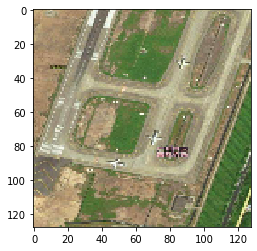

pred label=0,airplane(3_check\机场1.jpg)


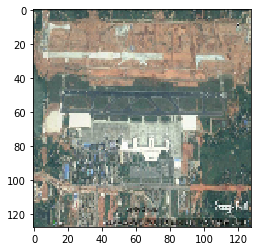

pred label=0,airplane(3_check\机场10.jpg)


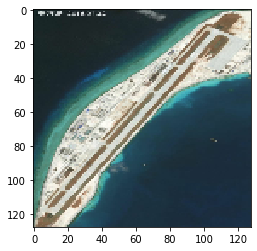

pred label=1,lake(3_check\机场11.jpg)


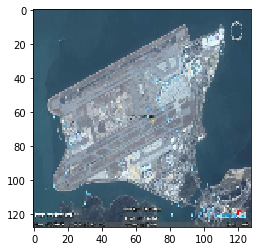

pred label=1,lake(3_check\机场12.jpg)


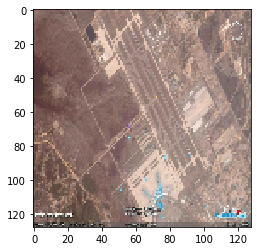

pred label=0,airplane(3_check\机场13.jpg)


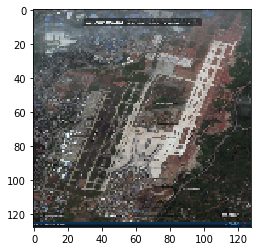

pred label=0,airplane(3_check\机场14.jpg)


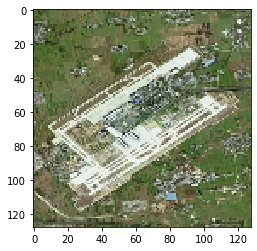

pred label=0,airplane(3_check\机场15.jpg)


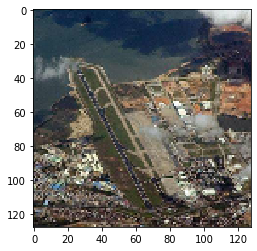

pred label=1,lake(3_check\机场16.jpg)


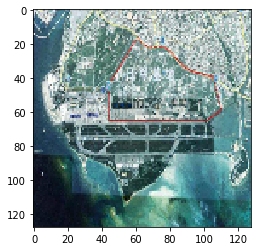

pred label=1,lake(3_check\机场17.jpg)


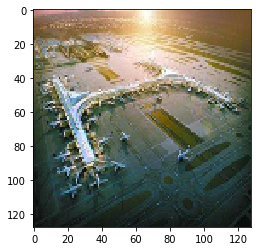

pred label=1,lake(3_check\机场18.jpg)


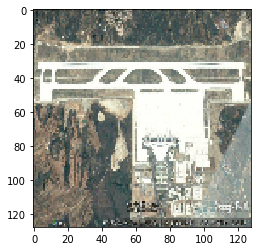

pred label=0,airplane(3_check\机场19.jpg)


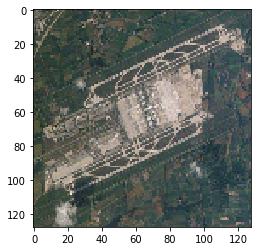

pred label=0,airplane(3_check\机场2.jpg)


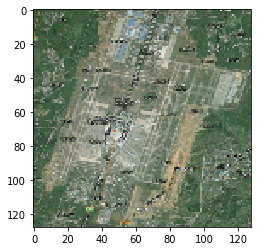

pred label=0,airplane(3_check\机场20.jpg)


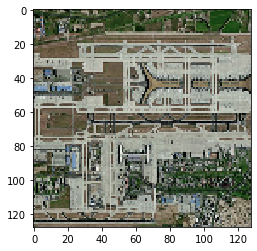

pred label=0,airplane(3_check\机场3.jpg)


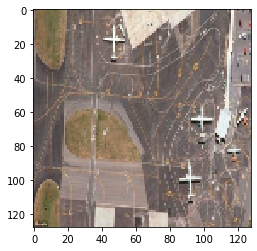

pred label=0,airplane(3_check\机场4.jpg)


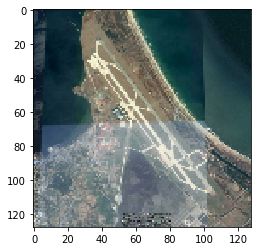

pred label=1,lake(3_check\机场5.jpg)


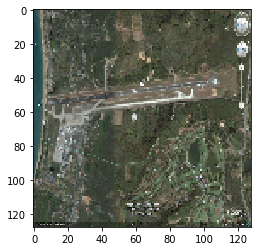

pred label=0,airplane(3_check\机场6.jpg)


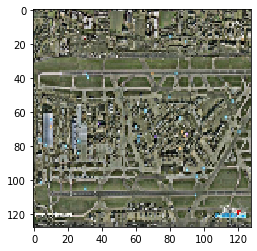

pred label=0,airplane(3_check\机场8.jpg)


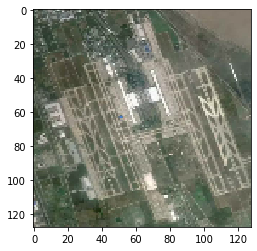

pred label=0,airplane(3_check\机场9.jpg)


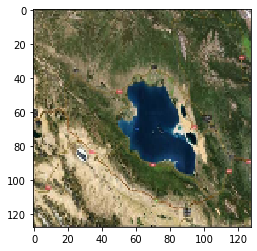

pred label=1,lake(3_check\湖1.jpg)


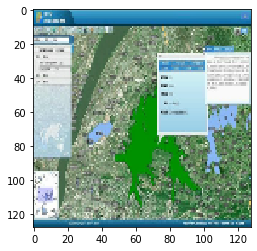

pred label=1,lake(3_check\湖10.jpg)


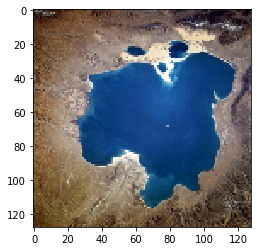

pred label=1,lake(3_check\湖11.jpg)


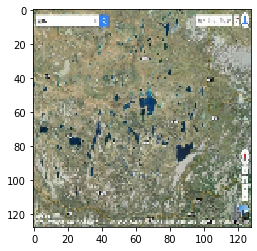

pred label=1,lake(3_check\湖12.jpg)


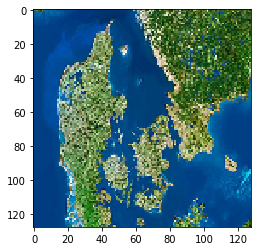

pred label=1,lake(3_check\湖13.jpg)


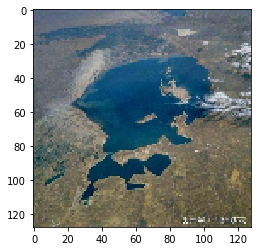

pred label=1,lake(3_check\湖14.jpg)


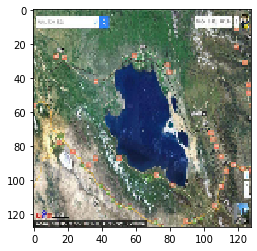

pred label=1,lake(3_check\湖15.jpg)


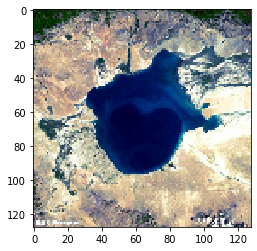

pred label=1,lake(3_check\湖2.jpg)


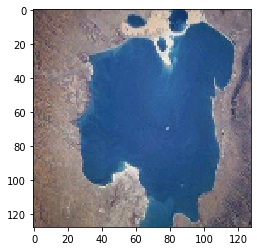

pred label=1,lake(3_check\湖3.jpg)


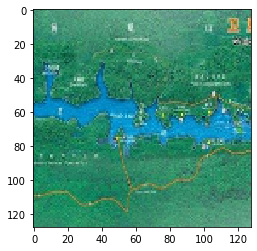

pred label=1,lake(3_check\湖4.jpg)


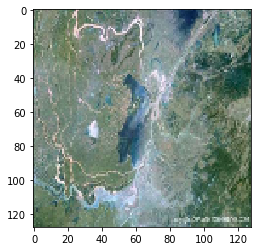

pred label=1,lake(3_check\湖5.jpg)


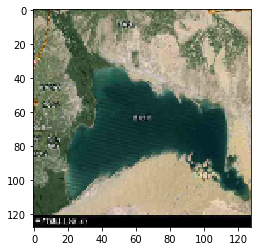

pred label=1,lake(3_check\湖6.jpg)


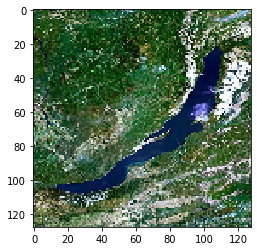

pred label=1,lake(3_check\湖7.jpg)


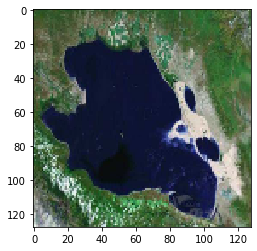

pred label=1,lake(3_check\湖8.jpg)


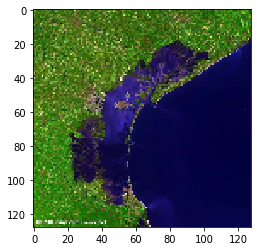

pred label=1,lake(3_check\湖9.jpg)


In [38]:
CHECK_PATH = './3_check'
check_image_paths = loadcheckfiles(CHECK_PATH)
for f in check_image_paths:
    imagepred(f , -1, withshow = True)

#模型的保存
model.save(SAVE_PATH + 'model')
#保存tensorflow格式的参数值
#model.save_weights(SAVE_PATH + 'model')
#保存keras格式的参数值（权重）
#model.save_weights(SAVE_PATH + 'model',save_format='HDF5')

# 序列化成json
import json
import pprint

json_str = model.to_json()
pprint.pprint(json.loads(json_str))
fresh_model = tf.keras.models.model_from_json(json_str) 